In [14]:
using LinearAlgebra
using Plots
import JSON
# using Quaternions
using StaticArrays, Rotations
using Distributed
using StaticArrays, BenchmarkTools
using Base.Threads
using CUDAnative
using CuArrays,CUDAdrv 
using Test
import Base: +, * , -, ^
# BASED ON https://github.com/jonhiller/Voxelyze

In [15]:
struct Vector3
    x::Float32
    y::Float32
    z::Float32
    function Vector3()
        x=0.0
        y=0.0
        z=0.0
        new(x,y,z)
    end
    function Vector3(x,y,z)
       new(x,y,z)
    end
end
struct Quaternion
    x::Float32
    y::Float32
    z::Float32
    w::Float32
    function Quaternion()
        x=0.0
        y=0.0
        z=0.0
        w=1.0
        new(x,y,z,w)
    end
    function Quaternion(x,y,z,w)
        new(x,y,z,w)
    end
end

+(f::Vector3, g::Vector3)=Vector3(f.x+g.x , f.y+g.y,f.z+g.z )
-(f::Vector3, g::Vector3)=Vector3(f.x-g.x , f.y-g.y,f.z-g.z )
*(f::Vector3, g::Vector3)=Vector3(f.x*g.x , f.y*g.y,f.z*g.z )

+(f::Vector3, g::Number)=Vector3(f.x+g , f.y+g,f.z+g )
-(f::Vector3, g::Number)=Vector3(f.x-g , f.y-g,f.z-g )
*(f::Vector3, g::Number)=Vector3(f.x*g , f.y*g,f.z*g )

+(g::Vector3, f::Number)=Vector3(f.x+g , f.y+g,f.z+g )
-(g::Vector3, f::Number)=Vector3(g-f.x , g-f.y,g-f.z )
*(g::Vector3, f::Number)=Vector3(f.x*g , f.y*g,f.z*g )

addX(f::Vector3, g::Number)=Vector3(f.x+g , f.y,f.z)
addY(f::Vector3, g::Number)=Vector3(f.x , f.y+g,f.z )
addZ(f::Vector3, g::Number)=Vector3(f.x , f.y,f.z+g )

function Base.show(io::IO, v::Vector3)
    print(io, "x:$(v.x), y:$(v.y), z:$(v.z)")
end

function Base.show(io::IO, v::Quaternion)
    print(io, "x:$(v.x), y:$(v.y), z:$(v.z), w:$(v.z)")
end

Base.Broadcast.broadcastable(q::Vector3) = Ref(q)

In [16]:
struct Node
    id::Int32
    position::Vector3
    restrained::Bool
    displacement::Vector3
    angle::Vector3
    force::Vector3
    currPosition::Vector3
    orient::Quaternion
    linMom::Vector3
    angMom::Vector3
    intForce::Vector3
    intMoment::Vector3
    moment::Vector3
    function Node()
        id=0
        position=Vector3()
        restrained=false
        displacement=Vector3()
        angle=Vector3()
        force=Vector3()
        currPosition=Vector3()
        orient=Quaternion()
        linMom=Vector3()
        angMom=Vector3()
        intForce=Vector3()
        intMoment=Vector3()
        moment=Vector3()
        new(id,position,restrained,displacement,angle,force,currPosition,orient,linMom,angMom,intForce,intMoment,moment)
    end
end
struct Edge
    id::Int32
    source::Int32 #change to Int32
    target::Int32
    area::Float32
    density::Float32
    stiffness::Float32
    stress::Float32
    axis::Vector3
    currentRestLength::Float32
    pos2::Vector3
    angle1v::Vector3
    angle2v::Vector3
    angle1::Quaternion
    angle2::Quaternion
    currentTransverseStrainSum::Float32
    ## add pos node and negative node
    ## add memory cuda??
    function Edge()
        id=0
        source=0
        target=0
        area=0.0
        density=0.0
        stiffness=0.0
        stress=0.0
        axis=Vector3(1.0,0.0,0.0)
        currentRestLength=0.0
        pos2=Vector3()
        angle1v=Vector3()
        angle2v=Vector3()
        angle1=Quaternion()
        angle2=Quaternion()
        currentTransverseStrainSum=0.0
        
        new(id,source,target,area,density,stiffness,stress,axis,currentRestLength,pos2,angle1v,angle2v,angle1,angle2,currentTransverseStrainSum)
    end
end

function Base.show(io::IO, v::Node)
    print(io, "node:$(v.id), position:($(v.position)), restrained:$(v.restrained)")
end

function Base.show(io::IO, v::Edge)
    print(io, "edge:$(v.id), source:$(v.source), target:$(v.target), stress:$(v.stress), axis:($(v.axis))")
end



In [17]:
# allowscalar(false)
m=Vector3(1.0,1.0,1.0)
mg=CuArray([m,m,m])
mm=mg.+m
# broadcast(+, mg, m)
# broadcast(addX, mg, 1)

# m=node
# println(m)
m=Node()
mg=CuArray([m,m,m])

3-element CuArray{Node,1,Nothing}:
 node:0, position:(x:0.0, y:0.0, z:0.0), restrained:false
 node:0, position:(x:0.0, y:0.0, z:0.0), restrained:false
 node:0, position:(x:0.0, y:0.0, z:0.0), restrained:false

In [18]:
###############################################################################################
setup = Dict()
open("../json/setupTest.json", "r") do f
    global setup
    dicttxt = String(read(f))  # file information to string
    setup=JSON.parse(dicttxt)  # parse and transform data
end

setup=setup["setup"]

Dict{String,Any} with 6 entries:
  "nodes"     => Any[Dict{String,Any}("degrees_of_freedom"=>Any[0, 1, 2, 3, 4, …
  "bar"       => false
  "animation" => Dict{String,Any}("speed"=>3,"exaggeration"=>2000,"showDisplacem…
  "viz"       => Dict{String,Any}("colorMap"=>0,"colorMaps"=>Any["coolwarm", "Y…
  "edges"     => Any[Dict{String,Any}("source"=>0,"area"=>1,"density"=>0.0284,"…
  "ndofs"     => 72

In [19]:
function initialize(setup)
	nodes      = setup["nodes"]
    edges      = setup["edges"]
    
    i=1
	# pre-calculate current position
	for node in nodes
        # element=parse(Int,node["id"][2:end])
        N_position[i,:]=[node["position"]["x"] node["position"]["y"] node["position"]["z"]]
        
        N_positionV[i]=Vector3(node["position"]["x"],node["position"]["y"],node["position"]["z"])
        
        append!(N_degrees_of_freedom,[node["degrees_of_freedom"]])
        N_restrained_degrees_of_freedom[i,:]=node["restrained_degrees_of_freedom"]
        N_restrained[i]=node["restrained_degrees_of_freedom"][1]
        append!(N_displacement,[[node["displacement"]["x"] node["displacement"]["y"] node["displacement"]["z"]]])
        append!(N_angle,[[node["angle"]["x"] node["angle"]["y"] node["angle"]["z"]]])
        append!(N_force,[[node["force"]["x"] node["force"]["y"] node["force"]["z"]]])
        append!(N_currPosition,[[node["position"]["x"] node["position"]["y"] node["position"]["z"]]])
        append!(N_orient,[Quat(1.0,0.0,0.0,0.0)])#quat
        append!(N_linMom,[[0 0 0]])
        append!(N_angMom,[[0 0 0]])
        append!(N_intForce,[[0 0 0]])
        append!(N_intMoment,[[0 0 0]])
        append!(N_moment,[[0 0 0]])
        
        # for dynamic simulations
        append!(N_posTimeSteps,[[]])
        append!(N_angTimeSteps,[[]])
        
        i=i+1
 
	end 
    
    i=1
	# pre-calculate the axis
	for edge in edges
        # element=parse(Int,edge["id"][2:end])
        
        # find the nodes that the lements connects
        fromNode = nodes[edge["source"]+1]
        toNode = nodes[edge["target"]+1]

        
        node1 = [fromNode["position"]["x"] fromNode["position"]["y"] fromNode["position"]["z"]]
        node2 = [toNode["position"]["x"] toNode["position"]["y"] toNode["position"]["z"]]
        
        length=norm(node2-node1)
        axis=normalize(collect(Iterators.flatten(node2-node1)))
        
        append!(E_source,[edge["source"]+1])
        append!(E_target,[edge["target"]+1])
        append!(E_area,[edge["area"]])
        append!(E_density,[edge["density"]])
        append!(E_stiffness,[edge["stiffness"]])
        append!(E_stress,[0])
        append!(E_axis,[axis])
        append!(E_currentRestLength,[length])
        append!(E_pos2,[[0 0 0]])
        append!(E_angle1v,[[0 0 0]])
        append!(E_angle2v,[[0 0 0]])
        append!(E_angle1,[Quat(1.0,0,0,0)]) #quat
        append!(E_angle2,[Quat(1.0,0,0,0)]) #quat
        append!(E_currentTransverseStrainSum,[0])
        
        # for dynamic simulations
        append!(E_stressTimeSteps,[[]])
        
        i=i+1
	end 
	
end

initialize (generic function with 1 method)

In [7]:
########
voxCount=0
linkCount=0
nodes      = setup["nodes"]
edges      = setup["edges"]
voxCount=size(nodes)[1]
linkCount=size(edges)[1]
strain =0 #todooo moveeee

############# nodes
N_position=fill(Vector3(),voxCount)
N_restrained=zeros(Bool, voxCount)
N_displacement=fill(Vector3(),voxCount)
N_angle=fill(Vector3(),voxCount)
N_currPosition=fill(Vector3(),voxCount)
N_linMom=fill(Vector3(),voxCount)
N_angMom=fill(Vector3(),voxCount)
N_intForce=fill(Vector3(),voxCount)
N_intMoment=fill(Vector3(),voxCount)
N_moment=fill(Vector3(),voxCount)
# N_posTimeSteps=[]
# N_angTimeSteps=[]
N_force=fill(Vector3(),voxCount)
N_orient=fill(Quaternion(),voxCount)

############# edges
E_source=fill(0,linkCount)
E_target=fill(0,linkCount)
E_area=fill(0.0F0,linkCount)
E_density=fill(0.0F0,linkCount)
E_stiffness=fill(0.0F0,linkCount)
E_stress=fill(0.0F0,linkCount)
E_axis=fill(Vector3(1.0,0.0,0.0),linkCount)
E_currentRestLength=fill(0.0F0,linkCount)
E_pos2=fill(Vector3(),linkCount)
E_angle1v=fill(Vector3(),linkCount)
E_angle2v=fill(Vector3(),linkCount)
E_angle1=fill(Quaternion(),voxCount)
E_angle2=fill(Quaternion(),voxCount)
E_currentTransverseStrainSum=fill(0.0F0,linkCount)# TODO remove ot incorporate
# E_stressTimeSteps=[]



initialize(setup)
N_position
N_positionGPU=CuArray(N_position)
N_restrained_degrees_of_freedomGPU=CuArray(N_restrained_degrees_of_freedom)
N_restrainedGPU=CuArray(N_restrained)
N_positionVGPU=CuArray(N_positionV)
# N_positionV .= ifelse.(N_restrained .==true, N_positionV, N_positionV .+ 1 )

12-element CuArray{Vector3,1,Nothing}:
 x:5.0, y:-5.0, z:0.0 
 x:0.0, y:-5.0, z:-5.0
 x:-5.0, y:-5.0, z:0.0
 x:0.0, y:-5.0, z:5.0 
 x:5.0, y:5.0, z:0.0  
 x:5.0, y:0.0, z:-5.0 
 x:5.0, y:0.0, z:5.0  
 x:-5.0, y:5.0, z:0.0 
 x:0.0, y:5.0, z:-5.0 
 x:0.0, y:5.0, z:5.0  
 x:-5.0, y:0.0, z:-5.0
 x:-5.0, y:0.0, z:5.0 

In [8]:
function trialGPU!(N_positionVGPU, N_restrainedGPU, vecGPU)
    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    stride = blockDim().x * gridDim().x
    for i = index:stride:length(vecGPU)
        @inbounds  N_positionVGPU[i]=ifelse(N_restrainedGPU[i], N_positionVGPU[i], N_positionVGPU[i] +vecGPU[i] )
    end
    return
end

# function trialGPU!(N_positionVGPU, N_restrainedGPU, vecGPU)
#     i = (blockIdx().x-1) * blockDim().x + threadIdx().x
#     N_positionVGPU[i]=ifelse(N_restrainedGPU[i], N_positionVGPU[i], N_positionVGPU[i] +vecGPU[i] )
#     return
# end

function bench_gpu!(N_positionVGPU, N_restrainedGPU, vecGPU)
    N=length(vecGPU)
    numblocks = ceil(Int, N/256)
    CuArrays.@sync begin
        @cuda threads=256 blocks=numblocks trialGPU!(N_positionVGPU, N_restrainedGPU, vecGPU)
    end
end

# @cuda threads=voxCount trialGPU(N_positionVGPU, N_restrainedGPU, vecGPU)
# N_positionVGPU

bench_gpu! (generic function with 1 method)

In [9]:
function trialCPU!(N_positionV, N_restrained, vec)
    for i in 1:length(vec)
        @inbounds N_positionV[i]=ifelse(N_restrained[i], N_positionV[i], N_positionV[i] +vec[i] )
    end
    return
end

# trialCPU!(N_positionV, N_restrained, vec)
# N_positionV

trialCPU! (generic function with 1 method)

In [ ]:
voxCount=2^12

############# nodes
N_positionV=fill(Vector3(0,0,0),voxCount)
N_restrained=zeros(Bool, voxCount)

N_restrainedGPU=CuArray(N_restrained)
N_positionVGPU=CuArray(N_positionV)

vec = fill(Vector3(1,1,1),voxCount)
vecGPU = CuArray(vec)

In [ ]:
# @btime bench_gpu!(N_positionVGPU, N_restrainedGPU, vecGPU)
@btime bench_gpu!(N_positionVGPU, N_restrainedGPU, vecGPU)

In [ ]:
@btime trialCPU!(N_positionV, N_restrained, vec)

In [ ]:
num=[2^8,2^9,2^10]
resulstGPU=[34.89e-6,35.6e-6,37.3e-6]
resulstCPU=[347.437e-9,676.6e-9,1.38e-6]

In [12]:
function bench()
    num=[]
    resultsGPU=[]
    resultsCPU=[]
    for i in 8:25
        voxCount=2^i

        ############# nodes
        N_positionV=fill(Vector3(0,0,0),voxCount)
        N_restrained=zeros(Bool, voxCount)

        N_restrainedGPU=CuArray(N_restrained)
        N_positionVGPU=CuArray(N_positionV)

        vec = fill(Vector3(1,1,1),voxCount)
        vecGPU = CuArray(vec)
        
        res=@timed bench_gpu!(N_positionVGPU, N_restrainedGPU, vecGPU)
        res1=@timed trialCPU!(N_positionV, N_restrained, vec)
        
        append!(num,voxCount)
        append!(resultsGPU,res[2])
        append!(resultsCPU,res1[2])
    end
    return num,resultsGPU,resultsCPU
end
num,resultsGPU,resultsCPU=bench()

(Any[256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304, 8388608, 16777216, 33554432], Any[0.0002236, 0.0001802, 0.0001789, 0.000165599, 0.0001807, 0.0001797, 0.0001961, 0.0002399, 0.0003058, 0.0005876, 0.0006443, 0.0008724, 0.001016701, 0.001034, 0.0014529, 0.0021805, 0.003616799, 0.0067031], Any[5.0e-7, 7.0e-7, 1.4e-6, 2.8e-6, 5.6e-6, 1.1001e-5, 2.3101e-5, 4.68e-5, 9.52e-5, 0.000197001, 0.0004137, 0.000879599, 0.0016901, 0.0033103, 0.0067236, 0.0133556, 0.0272343, 0.053784501])

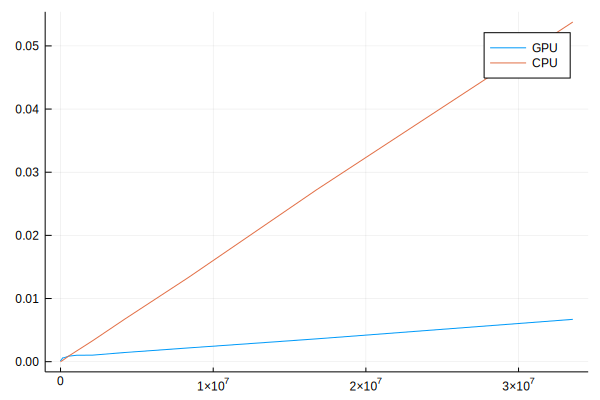

In [13]:
plot(num,[resultsGPU resultsCPU],label = ["GPU" "CPU"])

In [ ]:
N=100
function repeatGPU(N)
    for i in 1:N
        @cuda threads=voxCount trialGPU(N_positionVGPU, N_restrainedGPU, vecGPU)
    end
end
@btime repeatGPU(N)

In [ ]:
function repeatCPU(N)
    for i in 1:N
        trialCPU!(N_positionV, N_restrained, vec)
    end
end
@btime repeatCPU(N)

In [ ]:
# Trial 2

In [ ]:
N_positionV